In [24]:
%matplotlib inline

In [25]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

In [26]:
def load_directory(path):
    onlyfiles = ["%s/%s" %(path, f) for f in listdir(path) if isfile(join(path, f))]
    dfs = []
    
    for f in onlyfiles:
        dfs.append(pd.read_csv(f, sep='\t'))
    return pd.concat(dfs)

In [27]:
def load_experiments(path):
    onlyfiles = ["%s/%s" %(path, f) for f in listdir(path) if isfile(join(path, f))]
    dfs_diff = []
    dfs_sstab = []
    
    for f in onlyfiles[:40]:
        xp_df = pd.read_csv(f, sep='\t').reset_index().set_index("sim_step")
        max_index_diff = xp_df["eps_min_diff"].max()
        max_index_sstab = xp_df["eps_min_sstab"].max() 
        dfs_diff.append(xp_df[xp_df.index==max_index_diff*50])
        dfs_sstab.append(xp_df[xp_df.index==max_index_sstab*50])

    df_diff = pd.DataFrame(pd.concat(dfs_diff).reset_index().mean(axis=0)).T.set_index("sim_step")
    df_sstab = pd.DataFrame(pd.concat(dfs_sstab).reset_index().mean(axis=0)).T.set_index("sim_step")
    
    return pd.concat([df_diff, df_sstab])

In [28]:
def compute_average_out(path):
    onlyfiles = ["%s/%s" %(path, f) for f in listdir(path) if isfile(join(path, f))]
    dfs_diff = []
    dfs_sstab = []
    
    for f in onlyfiles[:40]:
        xp_df = pd.read_csv(f, sep='\t').reset_index().set_index("sim_step")
        max_index_diff = xp_df["eps_min_diff"].max()
        max_index_sstab = xp_df["eps_min_sstab"].max() 
        diff_line = xp_df[xp_df.index==max_index_diff*50]
        sstab_line = xp_df[xp_df.index==max_index_sstab*50]
        return diff_line, sstab_line
        dfs_diff.append(diff_line)
        dfs_sstab.append(sstab_line)

    df_diff = pd.DataFrame(pd.concat(dfs_diff).reset_index().mean(axis=0)).T.set_index("sim_step")
    df_sstab = pd.DataFrame(pd.concat(dfs_sstab).reset_index().mean(axis=0)).T.set_index("sim_step")
    
    return pd.concat([df_diff, df_sstab])

In [31]:
diff, sstab = compute_average_out("nnodes_100-distance_300-xpid_19/")

In [32]:
diff

,index,nmsg_diff,nmove_diff,itnmove_diff,energy_diff,delta_diff,nb_x_out_diff,nmsg_sstab,nmove_sstab,itnmove_sstab,...,delta_sstab,nb_x_out_sstab,run_id,xp_name,eps_min_diff,eps_min_sstab,degree_diff,degree_sstab,diameter,epsilon
sim_step,,,,,,,,,,,,,,,,,,,,,
10550,210,84200,4481,0,0.919,1.88,84,21441.0,2127.0,0.0,...,1.79,76.0,0,nnodes_100-distance_300-xpid_19,211,156,2.0,2.0,31,3.1


In [18]:
def plot_experiment_agg(xp_path):
    ltx_table = load_experiments(xp_path)
    
    with open("outputs/csv/%s.tex" %xp_path, "w+") as fp:
        ltx_table = ltx_table[["nmsg_diff", "delta_diff", "energy_diff", "nmove_diff",
                               "nmsg_sstab", 
                               "delta_sstab", "energy_sstab", "nmove_sstab"]]
        new_cols = []
        ltx_table["Time"] = ltx_table.index
        ltx_table["Algorithm"] = ["Diffusion", "Self-stab"]
        ltx_table["Degree"] = 2
        ltx_table = ltx_table[list(ltx_table.columns)[-3:] + list(ltx_table.columns)[:-3]]
        for col in ltx_table.columns:
            if col.endswith("_sstab"):
                new_cols.append(("Self-stab", col.split("_")[0]))
            elif col.endswith("_diff"):
                new_cols.append(("Diffusion", col.split("_")[0]))
            else:
                new_cols.append(("\multicolumn{3}{c}{}", col))
        print new_cols
        ltx_table.columns = pd.MultiIndex.from_tuples(new_cols)
    
    return ltx_table    

In [19]:
def plot_experiment(xp_path):
    df = load_directory(xp_path)
    gpdf = df.groupby(["sim_step", "xp_name"]).agg(np.mean).reset_index().set_index("sim_step")
    max_index = int(math.ceil(gpdf[["eps_min_diff", "eps_min_sstab"]].max().max()) + 2)
    max_index_diff = int(math.ceil(gpdf[["eps_min_diff"]].max().max()))
    max_index_sstab = int(math.ceil(gpdf[["eps_min_sstab"]].max().max()))    
    
    ltx_table = pd.concat([gpdf[gpdf.index==max_index_diff*50], gpdf[gpdf.index==max_index_sstab*50]])
    
    with open("outputs/csv/%s.tex" %xp_path, "w+") as fp:
        ltx_table = ltx_table[["nmsg_diff", "delta_diff", "energy_diff", "nmove_diff",
                               "nmsg_sstab", 
                               "delta_sstab", "energy_sstab", "nmove_sstab"]]
        new_cols = []
        ltx_table["Time"] = ltx_table.index
        ltx_table["Algorithm"] = ["Diffusion", "Self-stab"]
        ltx_table["Degree"] = gpdf["degree_sstab"]
        ltx_table = ltx_table[list(ltx_table.columns)[-3:] + list(ltx_table.columns)[:-3]]
        for col in ltx_table.columns:
            if col.endswith("_sstab"):
                new_cols.append(("Self-stab", col.split("_")[0]))
            elif col.endswith("_diff"):
                new_cols.append(("Diffusion", col.split("_")[0]))
            else:
                new_cols.append(("\multicolumn{3}{c}{}", col))
        print new_cols
        ltx_table.columns = pd.MultiIndex.from_tuples(new_cols)
        desc = xp_path.replace("-", " and ").replace("_", " ")
        label = xp_path.replace("-", "").replace("_", "")
        fp.write("\\begin{figure}\caption{Convergence iterations for experiment $description \label{tab:$label}}".replace("$xp_path", xp_path).\
                 replace("$description", desc).replace("$label", label))
        fp.write(ltx_table.to_latex(index=False, bold_rows=True, escape=False, 
                                    multirow=True, float_format="%.3lf", 
                                    column_format="r|l|r|r|r|r|r|r|r",
                                    multicolumn_format="|c"))        
        fp.write("\end{figure}")
        fp.write("""
\\begin{figure}
  \caption{Experiment with $description \label{fig:$label}}
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_delta.png}
    \caption{Maximum delta convergence \label{fig:$label_delta}}  
  \end{subfigure}
  %
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_nmsg.png}
    \caption{Number of exchanged messages    \label{fig:$label_nmsg}}
  \end{subfigure}
  
  \\begin{subfigure}[b]{0.5\\textwidth}
    \includegraphics[width=\\textwidth]{images/$xp_path_energy.png}
    \caption{Energy consumption \label{fig:$label_energy}}
  \end{subfigure}
\end{figure}
        """.replace("$xp_path", xp_path).replace("$description", desc).replace("$label", label))
        print ltx_table
    
    pgdf_sub = gpdf[gpdf.index <= max_index * 50]
    pgdf_sub.index = pgdf_sub.index.rename("Simulation time (ms)")
    plt.style.use('ggplot')
    pgdf_sub[["nmove_sstab", "nmove_diff"]].rename(columns={"nmove_sstab": "Self-stab - Moves",
                                              "nmove_diff": "Diffusion - Moves"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_nmove.png' %xp_path)
    
    pgdf_sub[["nmsg_sstab", "nmsg_diff"]].rename(columns={"nmsg_sstab": "Self-stab - Messages exchanged",
                                              "nmsg_diff": "Diffusion - Messages exchanged"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_nmsg.png' %xp_path)

    pgdf_sub[["delta_sstab", "delta_diff"]].rename(columns={"delta_sstab": "Self-stab - Maximum delta",
                                              "delta_diff": "Diffusion - Maximum delta"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_delta.png' %xp_path)

    pgdf_sub[["energy_sstab", "energy_diff"]].rename(columns={"energy_sstab": "Self-stab - Energy",
                                              "energy_diff": "Diffusion - Energy"}).plot(grid=True)
    plt.axvline(x=max_index_diff * 50, color='b', linestyle='--', label="Diffusion convergence state")
    plt.axvline(x=max_index_sstab * 50, color='r', linestyle='--', label="Self-stab convergence state")
    plt.legend(loc=0)
    plt.savefig('outputs/images/%s_energy.png' %xp_path)
    
    return ltx_table
    

In [20]:
def get_metrics_line(dist, df):
    deg = df["\multicolumn{3}{c}{}"]["Degree"].values[0]
    diff = df[df["\multicolumn{3}{c}{}"]["Algorithm"]=="Diffusion"]["Diffusion"].reset_index()
    sstab = df[df["\multicolumn{3}{c}{}"]["Algorithm"]=="Self-stab"]["Self-stab"].reset_index()

    vals = diff.values.ravel().tolist() + sstab.values.ravel().tolist()
    df = pd.DataFrame(index=[dist], data=[vals], columns=map(lambda x: "Diffusion_" + x, diff.columns.tolist()) 
             + map(lambda x: "Self-stab_" + x, sstab.columns.tolist()))
    df["Degree"] = deg
    return df

In [15]:
nnode=50
synth = get_metrics_line(nnode, plot_experiment_agg("nnodes_%d-distance_42" %nnode))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Diffusion', 'nmove'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy'), ('Self-stab', 'nmove')]


In [16]:
synth

,Diffusion_sim_step,Diffusion_nmsg,Diffusion_delta,Diffusion_energy,Diffusion_nmove,Self-stab_sim_step,Self-stab_nmsg,Self-stab_delta,Self-stab_energy,Self-stab_nmove,Degree
50,6300.0,25100.0,1.34,0.9515,1883.0,5300.0,9109.0,1.24,0.97065,903.0,2


In [13]:
synth["Self-stab_nmove"] / synth.index.values

50    18.06
Name: Self-stab_nmove, dtype: float64

## 10 nodes with 20 distance

In [14]:
xplist = []
for nnode in [50, 100, 200, 400, 600, 800]:
    xplist.append(get_metrics_line(nnode, plot_experiment_agg("nnodes_%d-distance_300-xpid_17" %nnode)))

[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Diffusion', 'nmove'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy'), ('Self-stab', 'nmove')]
[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Diffusion', 'nmove'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy'), ('Self-stab', 'nmove')]
[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multicolumn{3}{c}{}', 'Degree'), ('Diffusion', 'nmsg'), ('Diffusion', 'delta'), ('Diffusion', 'energy'), ('Diffusion', 'nmove'), ('Self-stab', 'nmsg'), ('Self-stab', 'delta'), ('Self-stab', 'energy'), ('Self-stab', 'nmove')]
[('\\multicolumn{3}{c}{}', 'Time'), ('\\multicolumn{3}{c}{}', 'Algorithm'), ('\\multi

## Scaling

In [15]:
plt.style.use('ggplot')

In [16]:
synth = pd.concat(xplist)

In [17]:
synth = synth.rename(columns={"Diffusion_nmove": "Diffusion nb iterations",
                              "Self-stab_nmove": "Self-stab nb iterations",
                              "Diffusion_nmsg": "Diffusion nb messages",
                              "Self-stab_nmsg": "Self-stab nb messages",
                              "Diffusion_energy": "Diffusion energy",
                              "Self-stab_energy": "Self-stab energy",})

In [18]:
synth

,Diffusion_sim_step,Diffusion nb messages,Diffusion_delta,Diffusion energy,Diffusion nb iterations,Self-stab_sim_step,Self-stab nb messages,Self-stab_delta,Self-stab energy,Self-stab nb iterations,Degree
50,6401.25,25461.10,1.28225,0.950550,1764.100,4588.75,7774.875,1.23225,0.974856,767.525,2
100,8590.00,68453.10,1.62650,0.933675,3804.800,6421.25,17075.050,1.55900,0.971002,1681.550,2
200,11291.25,180245.65,2.09675,0.912875,7794.350,8353.75,35904.100,2.06400,0.967601,3506.400,2
400,12347.50,394303.35,2.31325,0.904725,15648.250,9123.75,71945.175,2.25850,0.966806,7029.250,2
600,13838.75,663002.00,2.55950,0.893225,23519.375,10660.00,108685.225,2.50125,0.964994,10583.675,2
800,14616.25,933814.25,2.59200,0.887275,32565.150,11317.50,150241.925,2.52025,0.963521,14664.025,2


In [19]:
#synth["Self-stab_nmove"].values.reshape(1, 6)

In [20]:
from numpy import ones,vstack
from numpy.linalg import lstsq

points = [(x, y) for x, y in zip(synth.index.values, synth["Self-stab nb iterations"].values)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]

print "Line Solution is y = %.2lf x + %.2lf" %(m,c)

Line Solution is y = 18.32 x + -194.23


In [21]:
synth["Self-stab nb iterations"] / synth.index.values

50     15.350500
100    16.815500
200    17.532000
400    17.573125
600    17.639458
800    18.330031
Name: Self-stab nb iterations, dtype: float64

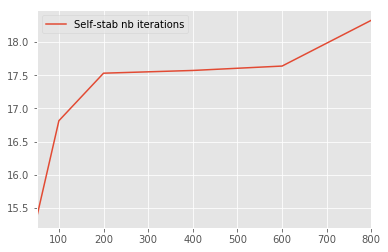

In [33]:
avg_move = synth[["Diffusion nb iterations", "Self-stab nb iterations"]].copy()
avg_move["Diffusion nb iterations"] /= avg_move.index.values
avg_move["Self-stab nb iterations"] /= avg_move.index.values

avg_move[["Self-stab nb iterations"]].plot()
plt.savefig('results/images/v2_avg_nmove.png')

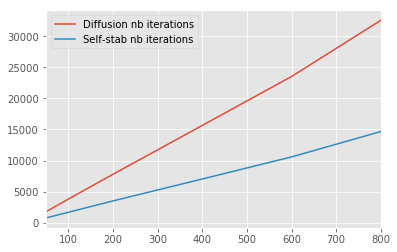

In [23]:
synth[["Diffusion nb iterations", "Self-stab nb iterations"]].plot()
plt.savefig('results/images/v2_nmove.png')

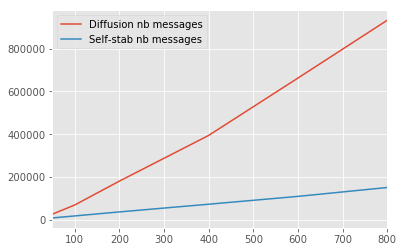

In [24]:
synth[["Diffusion nb messages", "Self-stab nb messages"]].plot()
plt.savefig('results/images/v2_nmsg.png')

In [25]:
synth["Diffusion nb messages"] / synth["Self-stab nb messages"]

50     3.274792
100    4.008955
200    5.020197
400    5.480609
600    6.100204
800    6.215404
dtype: float64

In [26]:
from numpy import ones,vstack
from numpy.linalg import lstsq

points = [(x, y) for x, y in zip(synth.index.values, synth["Self-stab nb messages"].values)]
x_coords, y_coords = zip(*points)
A = vstack([x_coords,ones(len(x_coords))]).T
m, c = lstsq(A, y_coords)[0]

print "Line Solution is y = %.2lf x + %.2lf" %(m,c)

Line Solution is y = 188.03 x + -2108.07


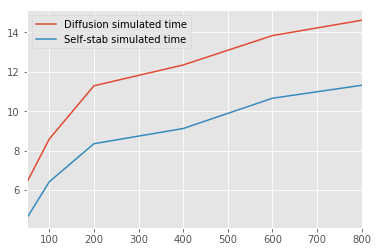

In [42]:
tm = synth[["Diffusion_sim_step", "Self-stab_sim_step"]] / 1000.
tm.rename(columns={"Diffusion_sim_step": "Diffusion simulated time",
                                                                   "Self-stab_sim_step": "Self-stab simulated time"}).plot()
plt.savefig('results/images/v2_parallel_simulated_time.png')

In [43]:
synth["Diffusion_seq_time"] = (synth["Diffusion nb iterations"] * 50)/1000.
synth["Self-stab_seq_time"] = (synth["Self-stab nb iterations"] * 50)/1000.

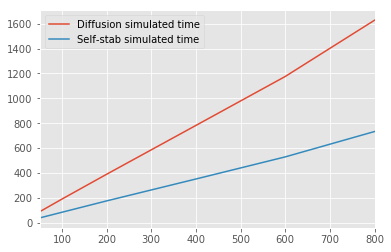

In [44]:
synth[["Diffusion_seq_time", "Self-stab_seq_time"]].rename(columns={"Diffusion_seq_time": "Diffusion simulated time",
                                                                   "Self-stab_seq_time": "Self-stab simulated time"}).plot()
plt.savefig('results/images/v2_seq_simulated_time.png')

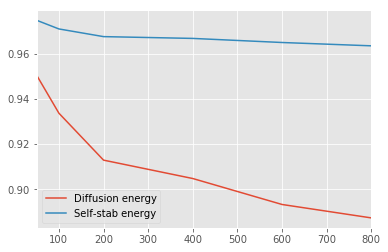

In [28]:
synth[["Diffusion energy", "Self-stab energy"]].plot()
plt.savefig('results/images/v2_energy.png')

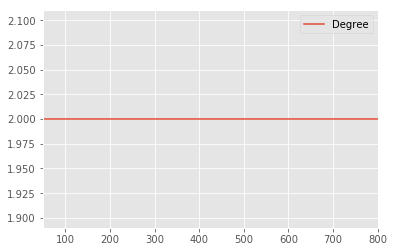

In [29]:
synth[["Degree"]].plot()
plt.savefig('outputs/images/scale_degree.png')